In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)


# Exploratory Climate Analysis

In [10]:
# Retrieve the last 12 months of precipitation data and plot the results
# Find out what is in the two tables
meas_data = session.query(Measurement).first()
meas_data.__dict__
#tobs, date, station, prcp, id

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x121232b70>,
 'tobs': 65.0,
 'prcp': 0.08,
 'station': 'USC00519397',
 'date': '2010-01-01',
 'id': 1}

In [11]:
station_data = session.query(Station).first()
station_data.__dict__
#elevation, latitude, station, longitude, name, id

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1212a7eb8>,
 'elevation': 3.0,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1}

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_row = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_row

('2017-08-23')

In [13]:
# One year ago = 2016-08-23
# Perform a query to retrieve the data and precipitation scores
one_year_object = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > '2016-08-23')
one_year_object

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# conn = engine.connect()
one_year_df = pd.read_sql(one_year_object.statement, session.bind)
one_year_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01


In [15]:
# NaN values
one_year_df.count()

# Pandas.plt with bar chart fills na values with 0

# Column data types
one_year_df['date'] = pd.to_datetime(one_year_df['date'])

In [16]:
# Sort the dataframe by date
one_year_sorted = one_year_df.set_index('date')
one_year_sorted.head()

,prcp
date,
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
2016-08-28,0.01


In [17]:
one_year_sorted.index.values

array(['2016-08-24T00:00:00.000000000', '2016-08-25T00:00:00.000000000',
       '2016-08-26T00:00:00.000000000', ...,
       '2017-08-21T00:00:00.000000000', '2017-08-22T00:00:00.000000000',
       '2017-08-23T00:00:00.000000000'], dtype='datetime64[ns]')

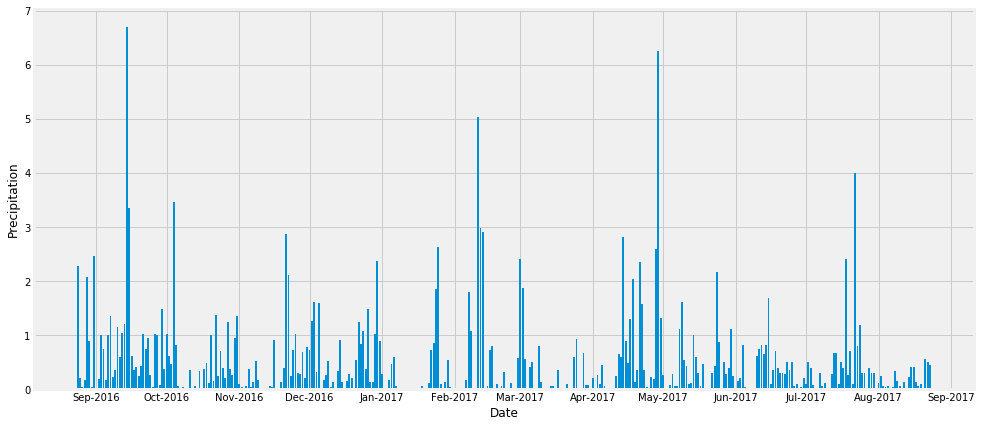

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
# matplotlib.mdates to fix x-axis, added import at top of file
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(one_year_sorted.index, one_year_sorted['prcp'])

#set ticks every month
ax.xaxis.set_major_locator(mdates.MonthLocator())

#set major ticks format
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b-%Y'))



ax.set_xlabel("Date")
ax.set_ylabel("Precipitation")
plt.show()

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
one_year_sorted.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).scalar()


9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.date).label('count'))\
                            .group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).all()

for station in station_count:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

most = session.query(Measurement.station, func.count(Measurement.date).label('count'))\
                            .group_by(Measurement.station).order_by(func.count(Measurement.date).desc()).first()

# first station id = most.station
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most.station).all()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most.station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most.station).all()

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temps_sql = session.query(Measurement.tobs).filter(Measurement.station == most.station, Measurement.date>'2016-08-23').all()


In [24]:
# Remove tuple brackets
temps = list(np.ravel(temps_sql))
temps

[77.0,
 80.0,
 80.0,
 75.0,
 73.0,
 78.0,
 77.0,
 78.0,
 80.0,
 80.0,
 78.0,
 78.0,
 78.0,
 73.0,
 74.0,
 80.0,
 79.0,
 77.0,
 80.0,
 76.0,
 79.0,
 75.0,
 79.0,
 78.0,
 79.0,
 78.0,
 78.0,
 76.0,
 74.0,
 77.0,
 78.0,
 79.0,
 79.0,
 77.0,
 80.0,
 78.0,
 78.0,
 78.0,
 77.0,
 79.0,
 79.0,
 79.0,
 79.0,
 75.0,
 76.0,
 73.0,
 72.0,
 71.0,
 77.0,
 79.0,
 78.0,
 79.0,
 77.0,
 79.0,
 77.0,
 78.0,
 78.0,
 78.0,
 78.0,
 77.0,
 74.0,
 75.0,
 76.0,
 73.0,
 76.0,
 74.0,
 77.0,
 76.0,
 76.0,
 74.0,
 75.0,
 75.0,
 75.0,
 75.0,
 71.0,
 63.0,
 70.0,
 68.0,
 67.0,
 77.0,
 74.0,
 77.0,
 76.0,
 76.0,
 75.0,
 76.0,
 75.0,
 73.0,
 75.0,
 73.0,
 75.0,
 74.0,
 75.0,
 74.0,
 75.0,
 73.0,
 75.0,
 73.0,
 73.0,
 74.0,
 70.0,
 72.0,
 70.0,
 67.0,
 67.0,
 69.0,
 70.0,
 68.0,
 69.0,
 69.0,
 66.0,
 65.0,
 68.0,
 62.0,
 75.0,
 70.0,
 69.0,
 76.0,
 76.0,
 74.0,
 73.0,
 71.0,
 74.0,
 74.0,
 72.0,
 71.0,
 72.0,
 74.0,
 69.0,
 67.0,
 72.0,
 70.0,
 64.0,
 63.0,
 63.0,
 62.0,
 70.0,
 70.0,
 62.0,
 62.0,
 63.0,
 65.0,
 69.0,

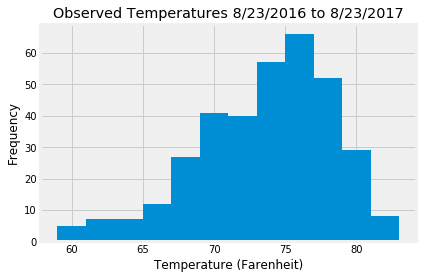

In [25]:
# Histogram

plt.hist(temps, bins=12)

plt.xlabel("Temperature (Farenheit)")
plt.ylabel("Frequency")

plt.title("Observed Temperatures 8/23/2016 to 8/23/2017")
plt.show()

In [26]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [27]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

# Trip dates: March 12-17
trip_temps=calc_temps('2017-03-12','2017-03-17')
print(trip_temps)

trip_temps_2 = list(np.ravel(trip_temps))

[(66.0, 71.57894736842105, 80.0)]


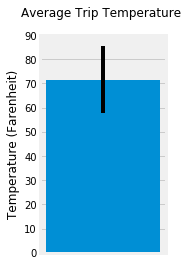

In [84]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
y = trip_temps_2[1]
yerr = (trip_temps_2[2]-trip_temps_2[0])

fig, ax = plt.subplots(figsize=(2,4))

plt.suptitle("Average Trip Temperature")
ax.bar(x=1, height=y, yerr=yerr)
ax.set_ylabel("Temperature (Farenheit)")
plt.xticks(np.arange(0.5,1.5,step=1))
plt.show()

